In [1]:
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import StratifiedShuffleSplit
from typing import Tuple
from tqdm import tqdm
import torch

In [2]:
import torch
import random
import numpy as np

def set_seed(seed=50):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [3]:
set_seed(50)

In [4]:
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

train_ds_full = torchvision.datasets.CIFAR10("cifar_root", transform=transform, download=True)
test_ds_full = torchvision.datasets.CIFAR10("cifar_root", transform=transform, train=False, download=True)

100%|██████████| 170M/170M [00:13<00:00, 13.0MB/s]


In [5]:
import numpy as np

TRAIN_SIZE = 5000
TEST_SIZE = 1000

indices = np.random.choice(len(train_ds_full), size=TRAIN_SIZE, replace=False)
train_ds = Subset(train_ds_full, indices)

indices = np.random.choice(len(test_ds_full), size=TEST_SIZE, replace=False)
test_ds = Subset(test_ds_full, indices)

train_dl = DataLoader(train_ds, batch_size=32, shuffle=True, pin_memory=True)
test_dl = DataLoader(test_ds, batch_size=32, shuffle=False, pin_memory=True)

In [6]:
def count_correct(
    y_pred: torch.Tensor, y_true: torch.Tensor
) -> torch.Tensor:
    preds = torch.argmax(y_pred, dim=1)
    return (preds == y_true).float().sum()

def validate(
    model: nn.Module,
    loss_fn: torch.nn.CrossEntropyLoss,
    dataloader: DataLoader
) -> Tuple[torch.Tensor, torch.Tensor]:
    loss = 0
    correct = 0
    all = 0
    for X_batch, y_batch in dataloader:
        y_pred = model(X_batch.cuda())
        all += len(y_pred)
        loss += loss_fn(y_pred, y_batch.cuda()).sum()
        correct += count_correct(y_pred, y_batch.cuda())
    return loss / all, correct / all

def fit(
    model: nn.Module, optimiser: optim.Optimizer,
    loss_fn: torch.nn.CrossEntropyLoss, train_dl: DataLoader,
    val_dl: DataLoader, epochs: int,
    print_metrics: str = True
):

  train_losses = []
  val_losses = []
  train_accuracies = []
  val_accuracies = []

  for epoch in range(epochs):
      model.train()
      for X_batch, y_batch in tqdm(train_dl):
          y_pred = model(X_batch.cuda())
          loss = loss_fn(y_pred, y_batch.cuda())

          loss.backward()
          optimiser.step()
          optimiser.zero_grad()

      if print_metrics:
          model.eval()
          with torch.no_grad():
              train_loss, train_acc = validate(
                  model=model, loss_fn=loss_fn, dataloader=train_dl
              )
              val_loss, val_acc = validate(
                  model=model, loss_fn=loss_fn, dataloader=val_dl
              )

              train_losses.append(train_loss.item())
              val_losses.append(val_loss.item())
              train_accuracies.append(train_acc.item())
              val_accuracies.append(val_acc.item())

              print(
                  f"Epoch {epoch}: "
                  f"train loss = {train_loss:.3f} (acc: {train_acc:.3f}), "
                  f"validation loss = {val_loss:.3f} (acc: {val_acc:.3f})"
              )

  model.eval()
  return train_losses, val_losses, train_accuracies, val_accuracies

In [7]:
from matplotlib import pyplot as plt

def compare_on_plots(model_1_scores, model_2_scores):
  fig, ax = plt.subplots(1, 2, figsize=(15, 8))
  epochs = len(model_1_scores['train_loss'])

  color1 = 'tab:blue'
  color2 = 'tab:orange'
  color3 = 'tab:green'

  ax[0].plot(range(epochs), model_1_scores['train_loss'], label=f'{model_1_scores["name"]} - Training', linestyle='--', color=color1)
  ax[0].plot(range(epochs), model_1_scores['val_loss'], label=f'{model_1_scores["name"]} - Validation', linestyle='-', color=color1)
  ax[0].plot(range(epochs), model_2_scores['train_loss'], label=f'{model_2_scores["name"]} - Training', linestyle='--', color=color2)
  ax[0].plot(range(epochs), model_2_scores['val_loss'], label=f'{model_2_scores["name"]} - Validation', linestyle='-', color=color2)
  ax[0].set_xlabel('Epochs')
  ax[0].set_ylabel('Value')
  ax[0].set_title('Loss functions comparison')
  ax[0].legend()

  ax[1].plot(range(epochs), model_1_scores['train_accuracy'], label=f'{model_1_scores["name"]} - Training', linestyle='--', color=color1)
  ax[1].plot(range(epochs), model_1_scores['val_accuracy'], label=f'{model_1_scores["name"]} - Validation', linestyle='-', color=color1)
  ax[1].plot(range(epochs), model_2_scores['train_accuracy'], label=f'{model_2_scores["name"]} - Training', linestyle='--', color=color2)
  ax[1].plot(range(epochs), model_2_scores['val_accuracy'], label=f'{model_2_scores["name"]} - Validation', linestyle='-', color=color2)
  ax[1].set_xlabel('Epochs')
  ax[1].set_ylabel('Value')
  ax[1].set_title('Accuracies comparison')
  ax[1].legend()

  plt.show()

In [33]:
import umap
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

def get_byol_representations(byol_encoder, features_tensor, device="cuda"):
    byol_encoder.eval()
    with torch.no_grad():
        features_tensor = features_tensor.to(device)
        encoded = byol_encoder(features_tensor)
        return encoded.cpu().numpy()

def plot_umap(features, labels, title="UMAP of BYOL Representations"):
    scaled_features = StandardScaler().fit_transform(features)

    reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, metric='euclidean')
    embedding = reducer.fit_transform(scaled_features)

    plt.figure(figsize=(10, 8))
    sns.scatterplot(
        x=embedding[:, 0],
        y=embedding[:, 1],
        hue=labels,
        palette='tab10',
        s=20,
        alpha=0.7
    )
    plt.title(title)
    plt.legend(title='Class', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

In [9]:
from torchvision.models import resnet18
resnet = resnet18(pretrained=True)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 220MB/s]


# Trening modelu baseline

In [ ]:
resnet = resnet18(pretrained=True)
resnet = resnet.cuda()
loss_fn = nn.CrossEntropyLoss()

optimiser = optim.Adam(resnet.parameters(), lr=1e-4)
resnet_results = fit(resnet, optimiser, loss_fn, train_dl, test_dl, epochs=20, print_metrics=True)

100%|██████████| 157/157 [00:17<00:00,  8.80it/s]


Epoch 0: train loss = 0.007 (acc: 0.938), validation loss = 0.021 (acc: 0.828)


100%|██████████| 157/157 [00:16<00:00,  9.47it/s]


Epoch 1: train loss = 0.001 (acc: 0.992), validation loss = 0.018 (acc: 0.841)


100%|██████████| 157/157 [00:16<00:00,  9.29it/s]


Epoch 2: train loss = 0.000 (acc: 0.998), validation loss = 0.017 (acc: 0.866)


100%|██████████| 157/157 [00:17<00:00,  8.91it/s]


Epoch 3: train loss = 0.000 (acc: 0.998), validation loss = 0.021 (acc: 0.858)


100%|██████████| 157/157 [00:17<00:00,  8.81it/s]


Epoch 4: train loss = 0.000 (acc: 1.000), validation loss = 0.018 (acc: 0.872)


100%|██████████| 157/157 [00:17<00:00,  8.73it/s]


Epoch 5: train loss = 0.000 (acc: 1.000), validation loss = 0.019 (acc: 0.867)


100%|██████████| 157/157 [00:17<00:00,  8.92it/s]


Epoch 6: train loss = 0.000 (acc: 1.000), validation loss = 0.017 (acc: 0.872)


100%|██████████| 157/157 [00:17<00:00,  8.84it/s]


Epoch 7: train loss = 0.000 (acc: 1.000), validation loss = 0.019 (acc: 0.863)


100%|██████████| 157/157 [00:17<00:00,  8.90it/s]


Epoch 8: train loss = 0.001 (acc: 0.991), validation loss = 0.020 (acc: 0.863)


100%|██████████| 157/157 [00:17<00:00,  8.89it/s]


Epoch 9: train loss = 0.001 (acc: 0.989), validation loss = 0.020 (acc: 0.856)


100%|██████████| 157/157 [00:17<00:00,  8.85it/s]


Epoch 10: train loss = 0.001 (acc: 0.992), validation loss = 0.022 (acc: 0.846)


100%|██████████| 157/157 [00:17<00:00,  8.84it/s]


Epoch 11: train loss = 0.000 (acc: 0.999), validation loss = 0.019 (acc: 0.870)


100%|██████████| 157/157 [00:17<00:00,  8.92it/s]


Epoch 12: train loss = 0.000 (acc: 0.999), validation loss = 0.018 (acc: 0.878)


100%|██████████| 157/157 [00:17<00:00,  8.87it/s]


Epoch 13: train loss = 0.000 (acc: 0.998), validation loss = 0.020 (acc: 0.859)


100%|██████████| 157/157 [00:17<00:00,  8.89it/s]


Epoch 14: train loss = 0.000 (acc: 0.997), validation loss = 0.021 (acc: 0.857)


100%|██████████| 157/157 [00:17<00:00,  8.88it/s]


Epoch 15: train loss = 0.000 (acc: 1.000), validation loss = 0.019 (acc: 0.876)


100%|██████████| 157/157 [00:17<00:00,  8.88it/s]


Epoch 16: train loss = 0.000 (acc: 0.998), validation loss = 0.022 (acc: 0.855)


100%|██████████| 157/157 [00:17<00:00,  8.89it/s]


Epoch 17: train loss = 0.000 (acc: 0.998), validation loss = 0.020 (acc: 0.860)


100%|██████████| 157/157 [00:17<00:00,  8.88it/s]


Epoch 18: train loss = 0.000 (acc: 0.996), validation loss = 0.020 (acc: 0.865)


100%|██████████| 157/157 [00:17<00:00,  8.87it/s]


Epoch 19: train loss = 0.001 (acc: 0.992), validation loss = 0.022 (acc: 0.856)


In [11]:
base_resnet_scores = {
    'name': 'Base Resnet',
    'train_loss': resnet_results[0],
    'val_loss': resnet_results[1],
    'train_accuracy': resnet_results[2],
    'val_accuracy': resnet_results[3]
}

# Modele BYOL

In [27]:
import torch
from torch import nn, optim, Tensor
from torch.utils.data import DataLoader
import torch.nn.functional as F
from typing import Tuple
import random
from torchvision import transforms as T
import copy

class MLP(nn.Module):
    def __init__(self, input_dim: int, hidden_dim: int, output_dim: int, plain_last: bool = False):
        super().__init__()
        layers = [
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(hidden_dim),
            nn.Linear(hidden_dim, output_dim),
        ]
        if not plain_last:
            layers += [nn.BatchNorm1d(output_dim), nn.ReLU(inplace=True)]

        self.net = nn.Sequential(*layers)

    def forward(self, x: Tensor) -> Tensor:
        return self.net(x)


class BYOLModel(nn.Module):
    def __init__(
        self,
        tau=0.99,
        input_dim=512*7*7
    ):
        super().__init__()
        self.online_encoder = nn.Sequential(
            nn.Linear(input_dim, 1024),
            nn.ReLU(),
            nn.Linear(1024, 84),
            nn.ReLU(),
        )
        self.online_projector = MLP(84, 84, 84, plain_last=False)
        self.online_predictor = MLP(84, 84, 84, plain_last=True)
        self.online_net = nn.Sequential(
            self.online_encoder,
            self.online_projector,
            self.online_predictor,
        )

        self.target_encoder = self.copy_and_freeze_module(self.online_encoder)
        self.target_projector = self.copy_and_freeze_module(self.online_projector)
        self.target_net = nn.Sequential(self.target_encoder, self.target_projector)

        self.aug_1 = nn.Identity()
        self.aug_2 = nn.Identity()

        self.tau = tau

    def forward(self, x: Tensor) -> tuple[Tensor, Tensor]:
        t = self.aug_1(x)
        t_prim = self.aug_2(x)

        q = self.online_net(t)
        q_sym = self.online_net(t_prim)

        with torch.no_grad():
            z_prim = self.target_net(t_prim)
            z_prim_sym = self.target_net(t)

        q = torch.cat([q, q_sym], dim=0)
        z_prim = torch.cat([z_prim, z_prim_sym], dim=0)

        return q, z_prim

    def forward_repr(self, x: Tensor) -> Tensor:
        return self.online_encoder(x)

    def byol_loss(self, q: Tensor, z_prim: Tensor) -> Tensor:
        q = F.normalize(q, dim=1)
        z_prim = F.normalize(z_prim, dim=1)
        return 2 - 2 * (q * z_prim).sum(dim=1).mean()

    @torch.no_grad()
    def update_target_network(self) -> None:
        for online_param, target_param in zip(self.online_encoder.parameters(), self.target_encoder.parameters()):
            target_param.data = self.tau * target_param.data + (1 - self.tau) * online_param.data

        for online_param, target_param in zip(self.online_projector.parameters(), self.target_projector.parameters()):
            target_param.data = self.tau * target_param.data + (1 - self.tau) * online_param.data

    @staticmethod
    def copy_and_freeze_module(model: nn.Module) -> nn.Module:
        copied_model = copy.deepcopy(model)
        for param in copied_model.parameters():
            param.requires_grad = False
        return copied_model

class FeatureSpaceAugmentation(nn.Module):
    def __init__(self, noise_std=0.1, dropout_p=0.1):
        super().__init__()
        self.noise_std = noise_std
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, x):
        noise = torch.randn_like(x) * self.noise_std
        x = x + noise
        x = self.dropout(x)
        return x

class BYOLModelWithHiddenAug(nn.Module):
    def __init__(
        self,
        tau=0.99,
        input_dim=512*7*7
    ):
        super().__init__()
        self.online_encoder = nn.Sequential(
            nn.Linear(input_dim, 1024),
            nn.ReLU(),
            nn.Linear(1024, 84),
            nn.ReLU(),
        )
        self.online_projector = MLP(84, 84, 84, plain_last=False)
        self.online_predictor = MLP(84, 84, 84, plain_last=True)
        self.online_net = nn.Sequential(
            self.online_encoder,
            self.online_projector,
            self.online_predictor,
        )

        self.target_encoder = self.copy_and_freeze_module(self.online_encoder)
        self.target_projector = self.copy_and_freeze_module(self.online_projector)
        self.target_net = nn.Sequential(self.target_encoder, self.target_projector)

        self.aug_1 = FeatureSpaceAugmentation(noise_std=0.05, dropout_p=0.05)
        self.aug_2 = FeatureSpaceAugmentation(noise_std=0.05, dropout_p=0.05)

        self.tau = tau

    def forward(self, x: Tensor) -> tuple[Tensor, Tensor]:
        t = self.aug_1(x)
        t_prim = self.aug_2(x)

        q = self.online_net(t)
        q_sym = self.online_net(t_prim)

        with torch.no_grad():
            z_prim = self.target_net(t_prim)
            z_prim_sym = self.target_net(t)

        q = torch.cat([q, q_sym], dim=0)
        z_prim = torch.cat([z_prim, z_prim_sym], dim=0)

        return q, z_prim

    def forward_repr(self, x: Tensor) -> Tensor:
        return self.online_encoder(x)

    def byol_loss(self, q: Tensor, z_prim: Tensor) -> Tensor:
        q = F.normalize(q, dim=1)
        z_prim = F.normalize(z_prim, dim=1)
        return 2 - 2 * (q * z_prim).sum(dim=1).mean()

    @torch.no_grad()
    def update_target_network(self) -> None:
        for online_param, target_param in zip(self.online_encoder.parameters(), self.target_encoder.parameters()):
            target_param.data = self.tau * target_param.data + (1 - self.tau) * online_param.data

        for online_param, target_param in zip(self.online_projector.parameters(), self.target_projector.parameters()):
            target_param.data = self.tau * target_param.data + (1 - self.tau) * online_param.data

    @staticmethod
    def copy_and_freeze_module(model: nn.Module) -> nn.Module:
        copied_model = copy.deepcopy(model)
        for param in copied_model.parameters():
            param.requires_grad = False
        return copied_model

class OrthogonalBYOLModel(nn.Module):
    def __init__(
        self,
        tau=0.99,
        input_dim=512*7*7
    ):
        super().__init__()
        self.online_encoder = nn.Sequential(
            nn.Linear(input_dim, 1024),
            nn.ReLU(),
            nn.Linear(1024, 84),
            nn.ReLU(),
        )
        self.online_projector = MLP(84, 84, 84, plain_last=False)
        self.online_predictor = MLP(84, 84, 84, plain_last=True)
        self.online_net = nn.Sequential(
            self.online_encoder,
            self.online_projector,
            self.online_predictor,
        )

        self.target_encoder = self.copy_and_freeze_module(self.online_encoder)
        self.target_projector = self.copy_and_freeze_module(self.online_projector)
        self.target_net = nn.Sequential(self.target_encoder, self.target_projector)

        self.aug_1 = nn.Identity()
        self.aug_2 = nn.Identity()

        self.tau = tau

    def forward(self, x: Tensor) -> tuple[Tensor, Tensor]:
        t = self.aug_1(x)
        t_prim = self.aug_2(x)

        q = self.online_net(t)
        q_sym = self.online_net(t_prim)

        with torch.no_grad():
            z_prim = self.target_net(t_prim)
            z_prim_sym = self.target_net(t)

        q = torch.cat([q, q_sym], dim=0)
        z_prim = torch.cat([z_prim, z_prim_sym], dim=0)

        return q, z_prim

    def forward_repr(self, x: Tensor) -> Tensor:
        return self.online_encoder(x)

    def byol_loss(self, q: Tensor, z_prim: Tensor, lambda_ortho: float = 1e-3) -> Tensor:
        q = F.normalize(q, dim=1)
        z_prim = F.normalize(z_prim, dim=1)
        loss = 2 - 2 * (q * z_prim).sum(dim=1).mean()

        sim_matrix = torch.matmul(q, q.T)
        identity = torch.eye(sim_matrix.size(0), device=q.device)
        off_diag = sim_matrix * (1 - identity)
        ortho_loss = (off_diag ** 2).sum() / q.size(0)

        return loss + lambda_ortho * ortho_loss

    @torch.no_grad()
    def update_target_network(self) -> None:
        for online_param, target_param in zip(self.online_encoder.parameters(), self.target_encoder.parameters()):
            target_param.data = self.tau * target_param.data + (1 - self.tau) * online_param.data

        for online_param, target_param in zip(self.online_projector.parameters(), self.target_projector.parameters()):
            target_param.data = self.tau * target_param.data + (1 - self.tau) * online_param.data

    @staticmethod
    def copy_and_freeze_module(model: nn.Module) -> nn.Module:
        copied_model = copy.deepcopy(model)
        for param in copied_model.parameters():
            param.requires_grad = False
        return copied_model

def train_byol(model: BYOLModel, dataloader: DataLoader, optimizer: optim.Optimizer, epochs=10, device="cuda"):
    model.to(device)
    model.train()
    avg_losses = []

    for epoch in range(epochs):
        running_loss = 0.0

        for batch_idx, (x, _) in enumerate(dataloader):
            x = x.to(device)

            q, z_prim = model(x)
            loss = model.byol_loss(q, z_prim)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            model.update_target_network()

            running_loss += loss.item()

            if batch_idx % 10 == 0:
                print(f"[Epoch {epoch+1}] [Batch {batch_idx}] Loss: {loss.item():.4f}")

        avg_loss = running_loss / len(dataloader)
        avg_losses.append(avg_loss)
        print(f"[Epoch {epoch+1}] Average Loss: {avg_loss:.4f}")

    return avg_losses


# Bazowy trening BYOL na reprezentacjach z Resneta

In [14]:
resnet = torchvision.models.resnet18(pretrained=True)
feature_extractor = nn.Sequential(*list(resnet.children())[:-2])

feature_extractor.eval()
all_features = []
all_labels = []

with torch.no_grad():
    for imgs, labels in train_dl:
        feats = feature_extractor(imgs)
        feats = torch.flatten(feats, start_dim=1)
        all_features.append(feats)
        all_labels.append(labels)



/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [15]:
all_features = torch.cat(all_features)
all_labels = torch.cat(all_labels)

In [16]:
class FeatureDataset(torch.utils.data.Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        x = self.features[idx]
        y = self.labels[idx]
        return x, y


In [17]:
byol_train_ds = FeatureDataset(all_features, all_labels)
byol_train_loader = torch.utils.data.DataLoader(byol_train_ds, batch_size=64, shuffle=True)

In [28]:
model_cifar_10_reps = BYOLModel()
optimizer = torch.optim.Adam(model_cifar_10_reps.parameters(), lr=1e-4, weight_decay=5e-5)
avg_losses = train_byol(model_cifar_10_reps, byol_train_loader, optimizer, epochs=30)

[Epoch 1] [Batch 0] Loss: 2.0598
[Epoch 1] [Batch 10] Loss: 1.8910
[Epoch 1] [Batch 20] Loss: 1.8673
[Epoch 1] [Batch 30] Loss: 1.7737
[Epoch 1] [Batch 40] Loss: 1.6737
[Epoch 1] [Batch 50] Loss: 1.5585
[Epoch 1] [Batch 60] Loss: 1.4404
[Epoch 1] [Batch 70] Loss: 1.3208
[Epoch 1] Average Loss: 1.6561
[Epoch 2] [Batch 0] Loss: 1.2838
[Epoch 2] [Batch 10] Loss: 1.1624
[Epoch 2] [Batch 20] Loss: 1.1016
[Epoch 2] [Batch 30] Loss: 1.0204
[Epoch 2] [Batch 40] Loss: 0.9760
[Epoch 2] [Batch 50] Loss: 0.9253
[Epoch 2] [Batch 60] Loss: 0.8718
[Epoch 2] [Batch 70] Loss: 0.8962
[Epoch 2] Average Loss: 1.0042
[Epoch 3] [Batch 0] Loss: 0.7977
[Epoch 3] [Batch 10] Loss: 0.7326
[Epoch 3] [Batch 20] Loss: 0.7427
[Epoch 3] [Batch 30] Loss: 0.6957
[Epoch 3] [Batch 40] Loss: 0.7122
[Epoch 3] [Batch 50] Loss: 0.6457
[Epoch 3] [Batch 60] Loss: 0.6589
[Epoch 3] [Batch 70] Loss: 0.5943
[Epoch 3] Average Loss: 0.6837
[Epoch 4] [Batch 0] Loss: 0.5768
[Epoch 4] [Batch 10] Loss: 0.5615
[Epoch 4] [Batch 20] Loss: 

In [29]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


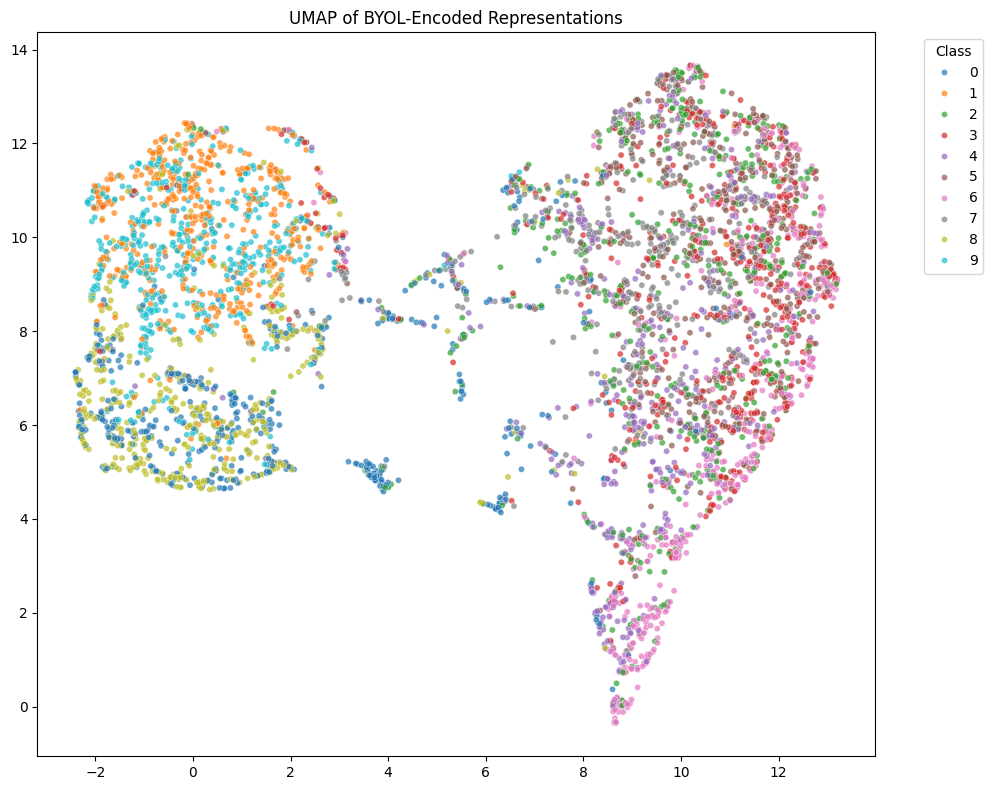

In [34]:
byol_features = get_byol_representations(model_cifar_10_reps.online_encoder, all_features, device=device)
plot_umap(byol_features, all_labels.numpy(), title="UMAP of BYOL-Encoded Representations")

In [35]:
class ResNetWithBYOLPooling(nn.Module):
    def __init__(self, byol_encoder, projection_dim, output_dim):
        super().__init__()
        resnet = torchvision.models.resnet18(pretrained=True)
        self.features = nn.Sequential(*list(resnet.children())[:-2])
        self.byol_encoder = byol_encoder
        self.classifier = nn.Linear(projection_dim, output_dim)

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.byol_encoder(x)
        logits = self.classifier(x)
        return logits


In [36]:
def train_epoch(model, dataloader, optimizer, criterion):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in tqdm(dataloader, leave=False):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    return running_loss / total, correct / total

def evaluate(model, dataloader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, leave=False):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    return running_loss / total, correct / total

In [37]:
def run_experiment(byol_encoder, freeze_byol=True, epochs=5, lr=1e-4, return_with_metrics=False):
    projection_dim = byol_encoder(torch.randn(1, 512*7*7).to(device)).shape[1]
    model = ResNetWithBYOLPooling(byol_encoder, projection_dim, output_dim=10).to(device)

    if freeze_byol:
        for param in model.byol_encoder.parameters():
            param.requires_grad = False

    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)
    criterion = nn.CrossEntropyLoss()

    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        train_loss, train_acc = train_epoch(model, train_dl, optimizer, criterion)
        test_loss, test_acc = evaluate(model, test_dl, criterion)
        print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
        print(f"Test Loss:  {test_loss:.4f} | Test Acc:  {test_acc:.4f}\n")
        train_losses.append(train_loss)
        val_losses.append(test_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(test_acc)

    if not return_with_metrics:
        return model
    else:
        return model, train_losses, val_losses, train_accuracies, val_accuracies

In [39]:
import copy

byol_encoder_frozen = copy.deepcopy(model_cifar_10_reps.online_encoder).to(device).eval()
byol_encoder_finetune = copy.deepcopy(model_cifar_10_reps.online_encoder).to(device)

In [40]:
print("===== Frozen BYOL Encoder =====")
frozen_model, train_losses, val_losses, train_accuracies, val_accuracies = run_experiment(byol_encoder_frozen, freeze_byol=True, epochs=20, return_with_metrics=True)

===== Frozen BYOL Encoder =====


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/20


Train Loss: 3.0148 | Train Acc: 0.2750
Test Loss:  1.5784 | Test Acc:  0.5140

Epoch 2/20


Train Loss: 1.1780 | Train Acc: 0.6630
Test Loss:  0.9284 | Test Acc:  0.7750

Epoch 3/20


Train Loss: 0.5535 | Train Acc: 0.8810
Test Loss:  0.7112 | Test Acc:  0.7970

Epoch 4/20


Train Loss: 0.2449 | Train Acc: 0.9556
Test Loss:  0.5838 | Test Acc:  0.8380

Epoch 5/20


Train Loss: 0.1273 | Train Acc: 0.9852
Test Loss:  0.5819 | Test Acc:  0.8500

Epoch 6/20


Train Loss: 0.0654 | Train Acc: 0.9946
Test Loss:  0.5839 | Test Acc:  0.8380

Epoch 7/20


Train Loss: 0.1000 | Train Acc: 0.9848
Test Loss:  0.5706 | Test Acc:  0.8350

Epoch 8/20


Train Loss: 0.0494 | Train Acc: 0.9934
Test Loss:  0.5508 | Test Acc:  0.8490

Epoch 9/20


Train Loss: 0.0220 | Train Acc: 0.9994
Test Loss:  0.5078 | Test Acc:  0.8570

Epoch 10/20


Train Loss: 0.0135 | Train Acc: 1.0000
Test Loss:  0.4888 | Test Acc:  0.8710

Epoch 11/20


Train Loss: 0.0197 | Train Acc: 0.9968
Test Loss:  0.5145 | Test Acc:  0.8700

Epoch 12/20


Train Loss: 0.0330 | Train Acc: 0.9944
Test Loss:  0.6015 | Test Acc:  0.8450

Epoch 13/20


Train Loss: 0.0440 | Train Acc: 0.9902
Test Loss:  0.5800 | Test Acc:  0.8480

Epoch 14/20


Train Loss: 0.0750 | Train Acc: 0.9816
Test Loss:  0.6805 | Test Acc:  0.8310

Epoch 15/20


Train Loss: 0.0388 | Train Acc: 0.9902
Test Loss:  0.5937 | Test Acc:  0.8380

Epoch 16/20


Train Loss: 0.0219 | Train Acc: 0.9944
Test Loss:  0.5661 | Test Acc:  0.8570

Epoch 17/20


Train Loss: 0.0152 | Train Acc: 0.9972
Test Loss:  0.5470 | Test Acc:  0.8650

Epoch 18/20


Train Loss: 0.0073 | Train Acc: 0.9996
Test Loss:  0.5042 | Test Acc:  0.8800

Epoch 19/20


Train Loss: 0.0034 | Train Acc: 1.0000
Test Loss:  0.5109 | Test Acc:  0.8770

Epoch 20/20


Train Loss: 0.0075 | Train Acc: 0.9988
Test Loss:  0.5518 | Test Acc:  0.8690



In [41]:
frozen_byol_scores = {
    'name': 'Resnet with frozen BYOL',
    'train_loss': train_losses,
    'val_loss': val_losses,
    'train_accuracy': train_accuracies,
    'val_accuracy': val_accuracies
}

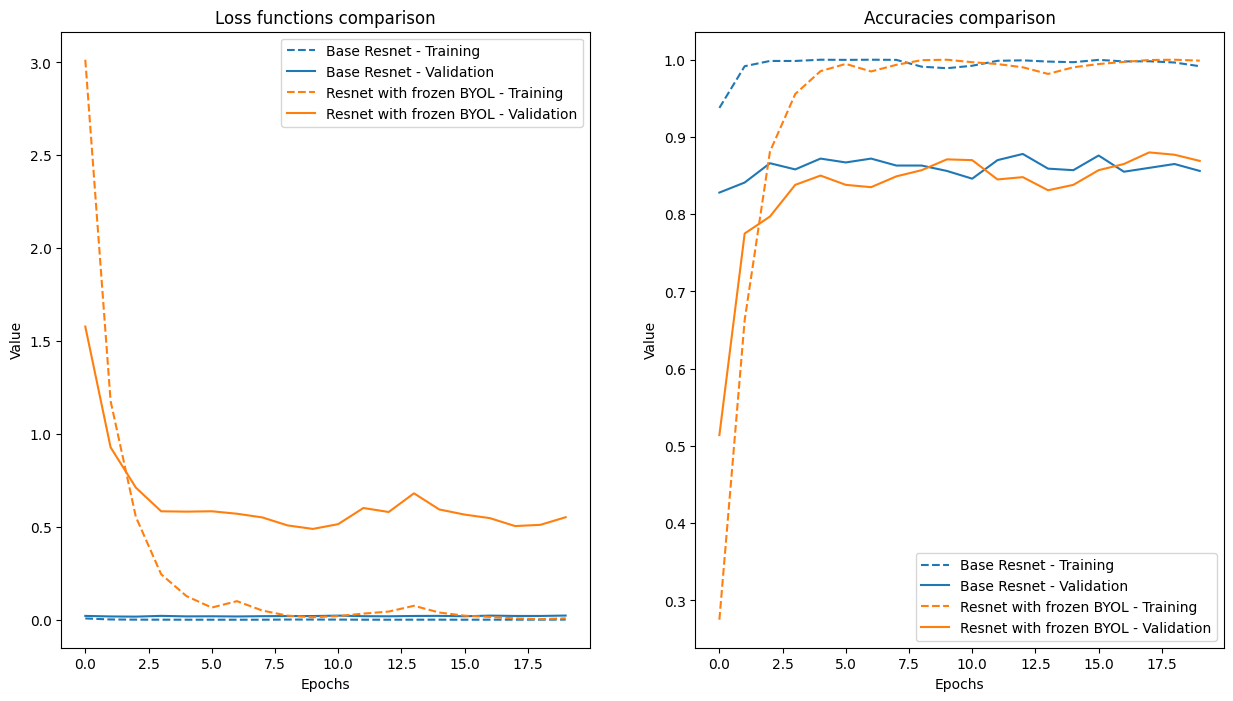

In [42]:
compare_on_plots(base_resnet_scores, frozen_byol_scores)

In [43]:
print("\n===== Fine-tuned BYOL Encoder =====")
finetuned_model, train_losses, val_losses, train_accuracies, val_accuracies = run_experiment(byol_encoder_finetune, freeze_byol=False, epochs=20, return_with_metrics=True)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



===== Fine-tuned BYOL Encoder =====
Epoch 1/20


Train Loss: 1.2715 | Train Acc: 0.6386
Test Loss:  0.5007 | Test Acc:  0.8330

Epoch 2/20


Train Loss: 0.2575 | Train Acc: 0.9172
Test Loss:  0.4930 | Test Acc:  0.8340

Epoch 3/20


Train Loss: 0.0642 | Train Acc: 0.9822
Test Loss:  0.5777 | Test Acc:  0.8440

Epoch 4/20


Train Loss: 0.0667 | Train Acc: 0.9788
Test Loss:  0.6401 | Test Acc:  0.8420

Epoch 5/20


Train Loss: 0.0420 | Train Acc: 0.9874
Test Loss:  0.6825 | Test Acc:  0.8430

Epoch 6/20


Train Loss: 0.0524 | Train Acc: 0.9838
Test Loss:  0.6548 | Test Acc:  0.8530

Epoch 7/20


Train Loss: 0.0924 | Train Acc: 0.9702
Test Loss:  0.5858 | Test Acc:  0.8690

Epoch 8/20


Train Loss: 0.0297 | Train Acc: 0.9924
Test Loss:  0.6119 | Test Acc:  0.8580

Epoch 9/20


Train Loss: 0.0336 | Train Acc: 0.9888
Test Loss:  0.7538 | Test Acc:  0.8360

Epoch 10/20


Train Loss: 0.0297 | Train Acc: 0.9904
Test Loss:  0.6639 | Test Acc:  0.8640

Epoch 11/20


Train Loss: 0.0409 | Train Acc: 0.9880
Test Loss:  0.7619 | Test Acc:  0.8510

Epoch 12/20


Train Loss: 0.0354 | Train Acc: 0.9880
Test Loss:  0.6110 | Test Acc:  0.8690

Epoch 13/20


Train Loss: 0.0503 | Train Acc: 0.9854
Test Loss:  0.7445 | Test Acc:  0.8540

Epoch 14/20


Train Loss: 0.0254 | Train Acc: 0.9916
Test Loss:  0.6404 | Test Acc:  0.8680

Epoch 15/20


Train Loss: 0.0497 | Train Acc: 0.9850
Test Loss:  0.8892 | Test Acc:  0.8390

Epoch 16/20


Train Loss: 0.0551 | Train Acc: 0.9826
Test Loss:  0.9700 | Test Acc:  0.8260

Epoch 17/20


Train Loss: 0.0399 | Train Acc: 0.9878
Test Loss:  0.7136 | Test Acc:  0.8600

Epoch 18/20


Train Loss: 0.0208 | Train Acc: 0.9940
Test Loss:  0.6735 | Test Acc:  0.8650

Epoch 19/20


Train Loss: 0.0106 | Train Acc: 0.9970
Test Loss:  0.6542 | Test Acc:  0.8700

Epoch 20/20


Train Loss: 0.0146 | Train Acc: 0.9954
Test Loss:  0.6843 | Test Acc:  0.8690



In [44]:
finetuned_byol_scores = {
    'name': 'Resnet with finetuned BYOL',
    'train_loss': train_losses,
    'val_loss': val_losses,
    'train_accuracy': train_accuracies,
    'val_accuracy': val_accuracies
}

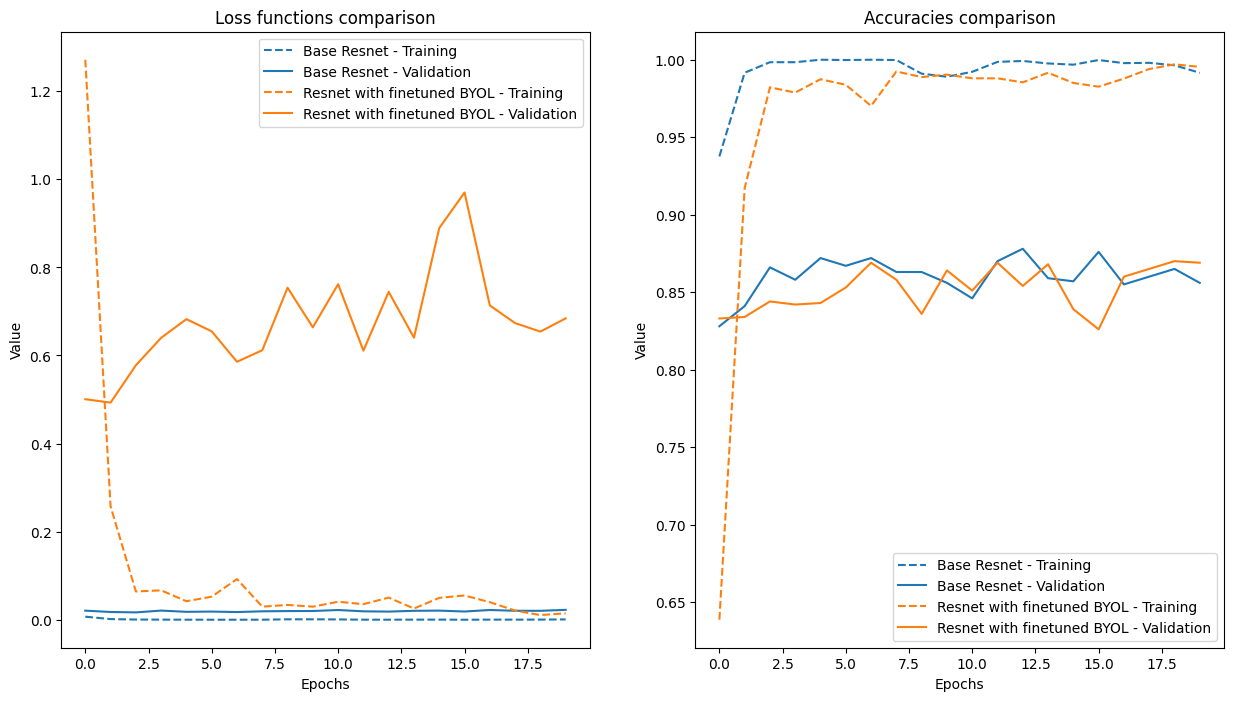

In [45]:
compare_on_plots(base_resnet_scores, finetuned_byol_scores)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


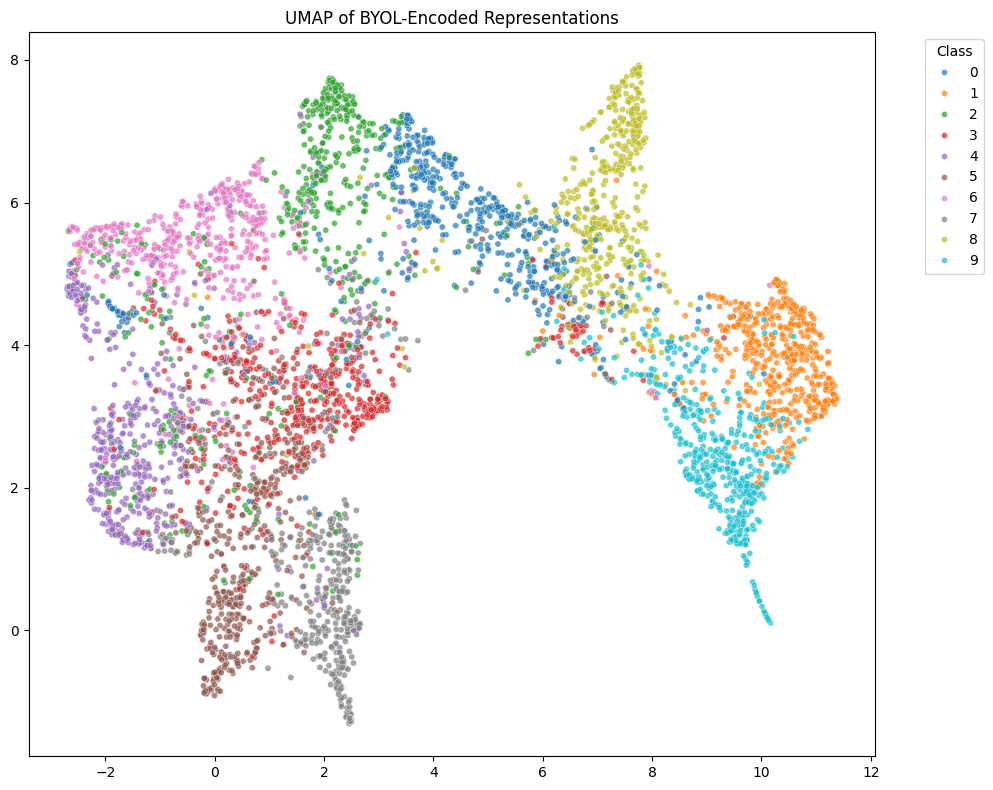

In [46]:
byol_features = get_byol_representations(byol_encoder_finetune, all_features, device=device)
plot_umap(byol_features, all_labels.numpy(), title="UMAP of BYOL-Encoded Representations")

# Augmentacje na reprezentacjach

In [47]:
import numpy as np

TRAIN_SIZE = 5000
TEST_SIZE = 1000

indices = np.random.choice(len(train_ds_full), size=TRAIN_SIZE, replace=False)
train_ds = Subset(train_ds_full, indices)

indices = np.random.choice(len(test_ds_full), size=TEST_SIZE, replace=False)
test_ds = Subset(test_ds_full, indices)

train_dl = DataLoader(train_ds, batch_size=128, shuffle=True, pin_memory=True)
test_dl = DataLoader(test_ds, batch_size=128, shuffle=False, pin_memory=True)

In [48]:
byol_train_ds = FeatureDataset(all_features, all_labels)
byol_train_loader = torch.utils.data.DataLoader(byol_train_ds, batch_size=128, shuffle=True)

In [49]:
model_cifar_10_reps = BYOLModelWithHiddenAug()
optimizer = torch.optim.Adam(model_cifar_10_reps.parameters(), lr=1e-4, weight_decay=1e-4)
avg_losses = train_byol(model_cifar_10_reps, byol_train_loader, optimizer, epochs=50)
avg_losses

[Epoch 1] [Batch 0] Loss: 1.9714
[Epoch 1] [Batch 10] Loss: 1.8565
[Epoch 1] [Batch 20] Loss: 1.7585
[Epoch 1] [Batch 30] Loss: 1.6113
[Epoch 1] Average Loss: 1.7550
[Epoch 2] [Batch 0] Loss: 1.5260
[Epoch 2] [Batch 10] Loss: 1.4334
[Epoch 2] [Batch 20] Loss: 1.3126
[Epoch 2] [Batch 30] Loss: 1.2427
[Epoch 2] Average Loss: 1.3381
[Epoch 3] [Batch 0] Loss: 1.1130
[Epoch 3] [Batch 10] Loss: 1.1016
[Epoch 3] [Batch 20] Loss: 1.0272
[Epoch 3] [Batch 30] Loss: 0.9573
[Epoch 3] Average Loss: 1.0283
[Epoch 4] [Batch 0] Loss: 0.9285
[Epoch 4] [Batch 10] Loss: 0.8823
[Epoch 4] [Batch 20] Loss: 0.8169
[Epoch 4] [Batch 30] Loss: 0.7757
[Epoch 4] Average Loss: 0.8257
[Epoch 5] [Batch 0] Loss: 0.7402
[Epoch 5] [Batch 10] Loss: 0.7065
[Epoch 5] [Batch 20] Loss: 0.6622
[Epoch 5] [Batch 30] Loss: 0.6299
[Epoch 5] Average Loss: 0.6707
[Epoch 6] [Batch 0] Loss: 0.6020
[Epoch 6] [Batch 10] Loss: 0.5890
[Epoch 6] [Batch 20] Loss: 0.5476
[Epoch 6] [Batch 30] Loss: 0.5097
[Epoch 6] Average Loss: 0.5521
[Epo

[1.7550287663936615,
 1.3380887866020204,
 1.0282682090997697,
 0.8256802797317505,
 0.6707420766353607,
 0.5521085679531097,
 0.4596371859312057,
 0.3907132714986801,
 0.33957224190235136,
 0.28811994194984436,
 0.26662677526474,
 0.24214303195476533,
 0.20376200079917908,
 0.1997566342353821,
 0.18950474858283997,
 0.17801782488822937,
 0.1952842116355896,
 0.1434788376092911,
 0.13702196776866912,
 0.1849011391401291,
 0.1225125551223755,
 0.1074730783700943,
 0.11081193685531616,
 0.10115154087543488,
 0.08474629521369934,
 0.07502799928188324,
 0.0816718429327011,
 0.10064524114131927,
 0.08647682964801788,
 0.07926513850688935,
 0.06489666998386383,
 0.05831875503063202,
 0.06569551229476929,
 0.06318975687026977,
 0.05003829598426819,
 0.0476883202791214,
 0.04179883003234863,
 0.049274498224258424,
 0.0449828028678894,
 0.04443947076797485,
 0.038675862550735476,
 0.0427218496799469,
 0.042801383137702945,
 0.03652449250221253,
 0.030714350938796996,
 0.031889724731445315,
 0.0

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


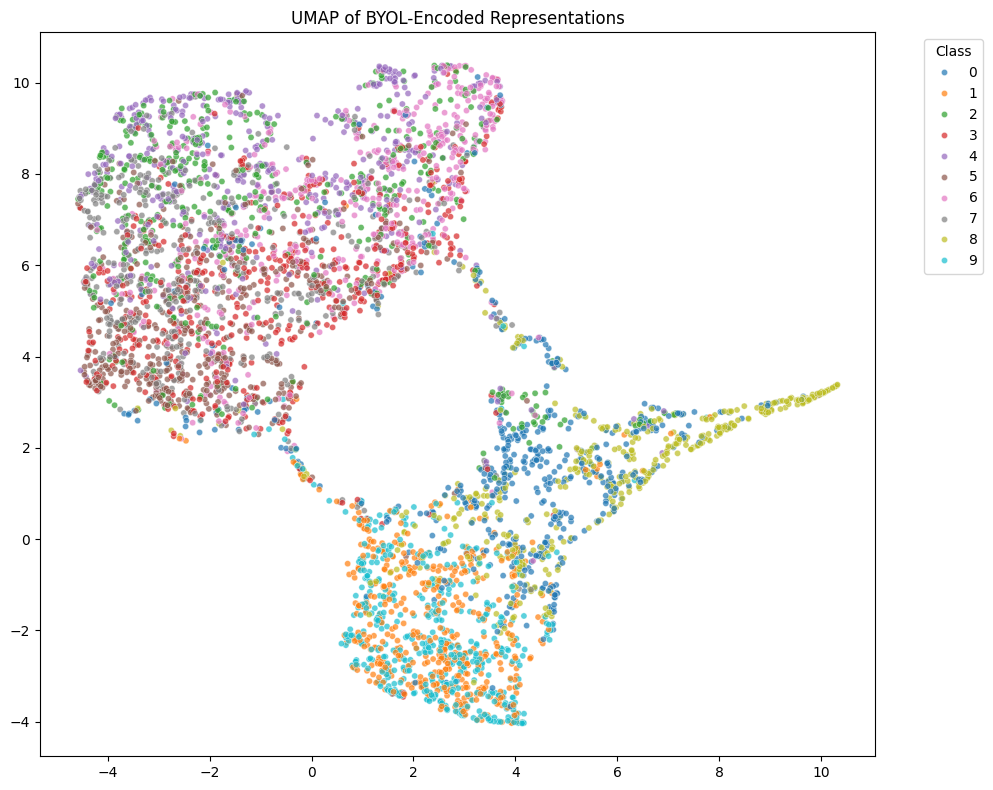

In [50]:
byol_features = get_byol_representations(model_cifar_10_reps.online_encoder, all_features, device=device)
plot_umap(byol_features, all_labels.numpy(), title="UMAP of BYOL-Encoded Representations")

In [51]:
import copy

byol_encoder_frozen = copy.deepcopy(model_cifar_10_reps.online_encoder).to(device).eval()
byol_encoder_finetune = copy.deepcopy(model_cifar_10_reps.online_encoder).to(device)

In [52]:
print("===== Frozen BYOL Encoder =====")
frozen_model, train_losses, val_losses, train_accuracies, val_accuracies = run_experiment(byol_encoder_frozen, freeze_byol=True, epochs=20, return_with_metrics=True)
train_losses, val_losses, train_accuracies, val_accuracies

===== Frozen BYOL Encoder =====


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/20


Train Loss: 5.8848 | Train Acc: 0.1634
Test Loss:  2.3617 | Test Acc:  0.2620

Epoch 2/20


Train Loss: 1.9434 | Train Acc: 0.3614
Test Loss:  1.6446 | Test Acc:  0.4680

Epoch 3/20


Train Loss: 1.2425 | Train Acc: 0.6208
Test Loss:  1.1822 | Test Acc:  0.6540

Epoch 4/20


Train Loss: 0.7763 | Train Acc: 0.8046
Test Loss:  0.9247 | Test Acc:  0.7500

Epoch 5/20


Train Loss: 0.4881 | Train Acc: 0.8956
Test Loss:  0.7807 | Test Acc:  0.7810

Epoch 6/20


Train Loss: 0.2866 | Train Acc: 0.9510
Test Loss:  0.6880 | Test Acc:  0.8080

Epoch 7/20


Train Loss: 0.1710 | Train Acc: 0.9786
Test Loss:  0.6720 | Test Acc:  0.8190

Epoch 8/20


Train Loss: 0.1266 | Train Acc: 0.9872
Test Loss:  0.6303 | Test Acc:  0.8220

Epoch 9/20


Train Loss: 0.0755 | Train Acc: 0.9954
Test Loss:  0.6300 | Test Acc:  0.8290

Epoch 10/20


Train Loss: 0.0504 | Train Acc: 0.9986
Test Loss:  0.6143 | Test Acc:  0.8240

Epoch 11/20


Train Loss: 0.0370 | Train Acc: 0.9992
Test Loss:  0.6446 | Test Acc:  0.8250

Epoch 12/20


Train Loss: 0.0834 | Train Acc: 0.9862
Test Loss:  0.7400 | Test Acc:  0.8150

Epoch 13/20


Train Loss: 0.0400 | Train Acc: 0.9980
Test Loss:  0.6750 | Test Acc:  0.8270

Epoch 14/20


Train Loss: 0.0459 | Train Acc: 0.9948
Test Loss:  0.7616 | Test Acc:  0.8020

Epoch 15/20


Train Loss: 0.1187 | Train Acc: 0.9780
Test Loss:  0.7367 | Test Acc:  0.8210

Epoch 16/20


Train Loss: 0.1114 | Train Acc: 0.9742
Test Loss:  0.6823 | Test Acc:  0.8130

Epoch 17/20


Train Loss: 0.0508 | Train Acc: 0.9936
Test Loss:  0.6903 | Test Acc:  0.8200

Epoch 18/20


Train Loss: 0.0798 | Train Acc: 0.9850
Test Loss:  0.7416 | Test Acc:  0.8120

Epoch 19/20


Train Loss: 0.0699 | Train Acc: 0.9848
Test Loss:  0.6650 | Test Acc:  0.8350

Epoch 20/20


Train Loss: 0.0205 | Train Acc: 0.9992
Test Loss:  0.6584 | Test Acc:  0.8390



([5.8847789897918705,
  1.9434011932373048,
  1.2425471475601195,
  0.7763494976043701,
  0.488135062122345,
  0.2865550094604492,
  0.17095258502960206,
  0.12661776220798493,
  0.07545488984584808,
  0.05036905226707458,
  0.03699032745361328,
  0.08343901963233948,
  0.040007148027420045,
  0.0459152889251709,
  0.11871113348007202,
  0.11140297553539276,
  0.05078818101882934,
  0.07978004279136658,
  0.06990350002646446,
  0.02052844657897949],
 [2.3617004222869875,
  1.6445906085968018,
  1.1821661338806153,
  0.9246832070350647,
  0.7806816811561584,
  0.6879526979923248,
  0.671953492641449,
  0.6303257172107697,
  0.6299860181808472,
  0.6142592380046844,
  0.6445598421096802,
  0.7399583353996276,
  0.6750117084980011,
  0.7616347703933716,
  0.736724663734436,
  0.6822859530448914,
  0.6903352892398834,
  0.7415511765480042,
  0.6650273201465606,
  0.6584354944229126],
 [0.1634,
  0.3614,
  0.6208,
  0.8046,
  0.8956,
  0.951,
  0.9786,
  0.9872,
  0.9954,
  0.9986,
  0.9992

In [53]:
hidden_augs_frozen_byol_scores = {
    'name': 'Resnet with frozen BYOL (hidden augmentations)',
    'train_loss': train_losses,
    'val_loss': val_losses,
    'train_accuracy': train_accuracies,
    'val_accuracy': val_accuracies
}

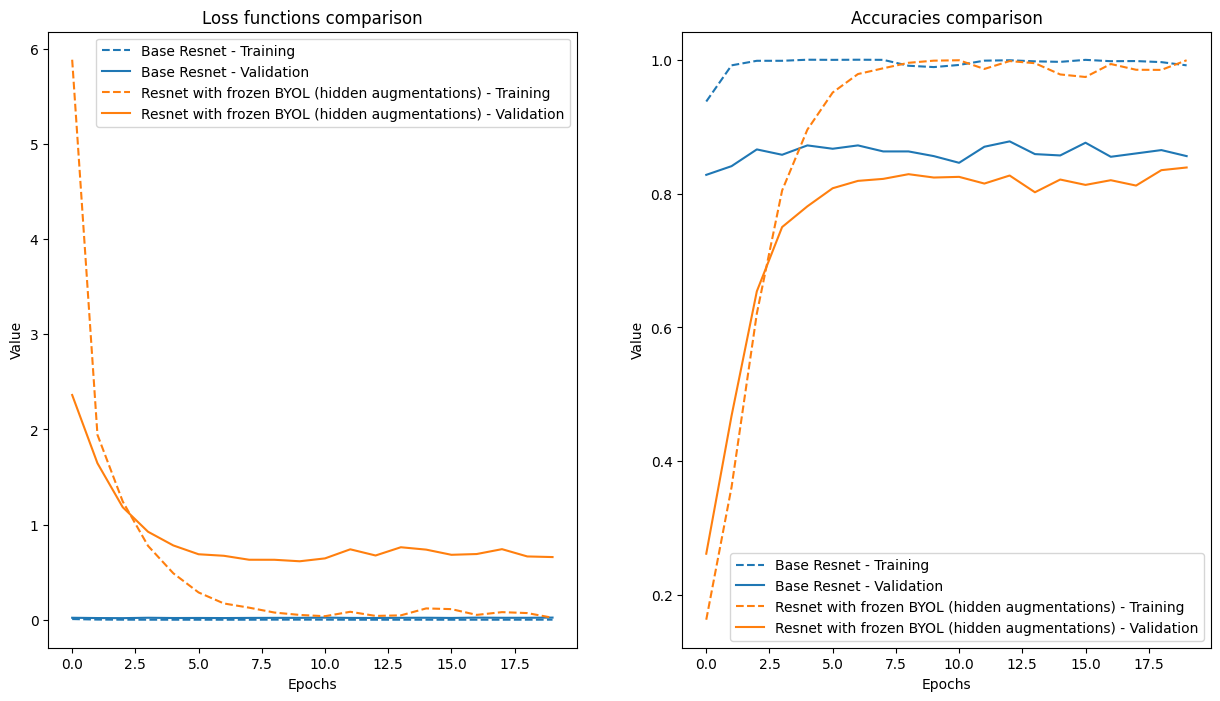

In [54]:
compare_on_plots(base_resnet_scores, hidden_augs_frozen_byol_scores)

In [55]:
print("\n===== Fine-tuned BYOL Encoder =====")
finetuned_model, train_losses, val_losses, train_accuracies, val_accuracies = run_experiment(byol_encoder_finetune, freeze_byol=False, epochs=20, return_with_metrics=True)


===== Fine-tuned BYOL Encoder =====


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/20


Train Loss: 3.7988 | Train Acc: 0.2366
Test Loss:  1.4119 | Test Acc:  0.4980

Epoch 2/20


Train Loss: 1.0379 | Train Acc: 0.6560
Test Loss:  0.7942 | Test Acc:  0.7300

Epoch 3/20


Train Loss: 0.4629 | Train Acc: 0.8548
Test Loss:  0.5861 | Test Acc:  0.8010

Epoch 4/20


Train Loss: 0.1712 | Train Acc: 0.9542
Test Loss:  0.4717 | Test Acc:  0.8560

Epoch 5/20


Train Loss: 0.0504 | Train Acc: 0.9904
Test Loss:  0.4733 | Test Acc:  0.8530

Epoch 6/20


Train Loss: 0.0194 | Train Acc: 0.9990
Test Loss:  0.4808 | Test Acc:  0.8540

Epoch 7/20


Train Loss: 0.0314 | Train Acc: 0.9940
Test Loss:  0.5340 | Test Acc:  0.8530

Epoch 8/20


Train Loss: 0.0779 | Train Acc: 0.9768
Test Loss:  0.5192 | Test Acc:  0.8480

Epoch 9/20


Train Loss: 0.0120 | Train Acc: 0.9986
Test Loss:  0.4917 | Test Acc:  0.8680

Epoch 10/20


Train Loss: 0.0031 | Train Acc: 0.9998
Test Loss:  0.4806 | Test Acc:  0.8670

Epoch 11/20


Train Loss: 0.0018 | Train Acc: 0.9998
Test Loss:  0.5387 | Test Acc:  0.8560

Epoch 12/20


Train Loss: 0.0471 | Train Acc: 0.9878
Test Loss:  0.7154 | Test Acc:  0.8390

Epoch 13/20


Train Loss: 0.0866 | Train Acc: 0.9738
Test Loss:  0.6883 | Test Acc:  0.8270

Epoch 14/20


Train Loss: 0.0185 | Train Acc: 0.9958
Test Loss:  0.5716 | Test Acc:  0.8500

Epoch 15/20


Train Loss: 0.0049 | Train Acc: 0.9992
Test Loss:  0.5783 | Test Acc:  0.8640

Epoch 16/20


Train Loss: 0.0118 | Train Acc: 0.9964
Test Loss:  0.6440 | Test Acc:  0.8510

Epoch 17/20


Train Loss: 0.0086 | Train Acc: 0.9972
Test Loss:  0.6196 | Test Acc:  0.8500

Epoch 18/20


Train Loss: 0.0584 | Train Acc: 0.9818
Test Loss:  0.7126 | Test Acc:  0.8240

Epoch 19/20


Train Loss: 0.0118 | Train Acc: 0.9972
Test Loss:  0.5987 | Test Acc:  0.8490

Epoch 20/20


Train Loss: 0.0141 | Train Acc: 0.9962
Test Loss:  0.6306 | Test Acc:  0.8620



In [56]:
hidden_augs_finetuned_byol_scores = {
    'name': 'Resnet with finetuned BYOL (hidden augmentations)',
    'train_loss': train_losses,
    'val_loss': val_losses,
    'train_accuracy': train_accuracies,
    'val_accuracy': val_accuracies
}

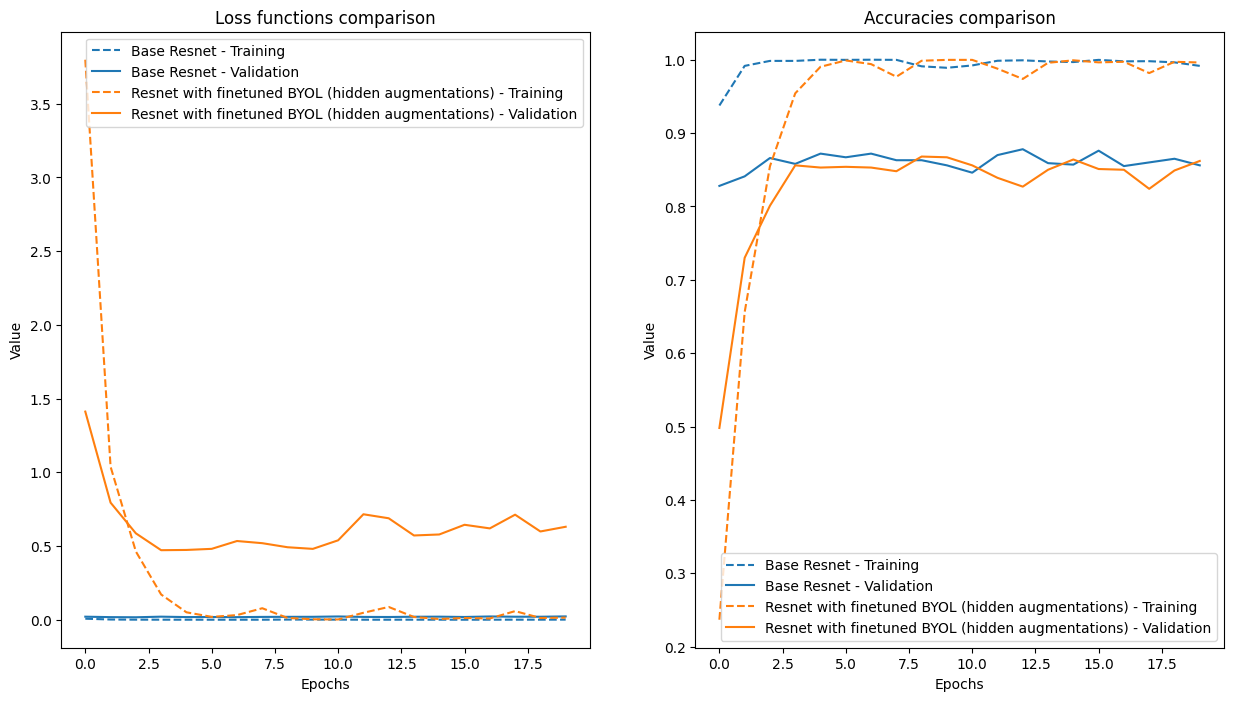

In [57]:
compare_on_plots(base_resnet_scores, hidden_augs_finetuned_byol_scores)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


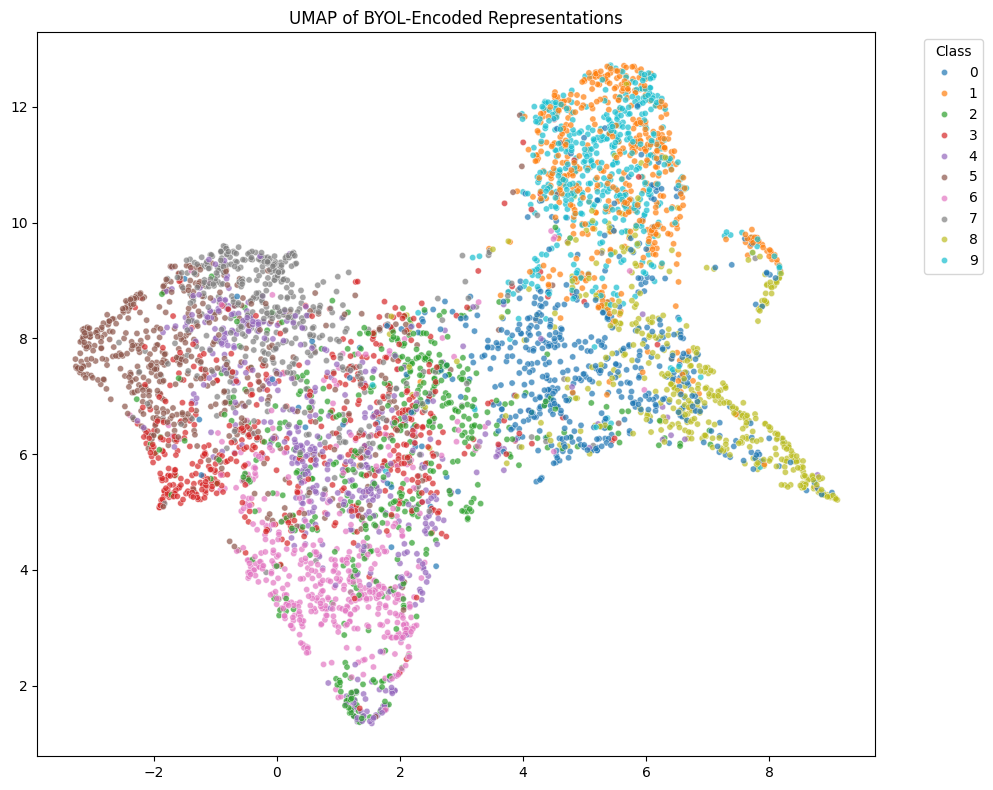

In [58]:
byol_features = get_byol_representations(byol_encoder_finetune, all_features, device=device)
plot_umap(byol_features, all_labels.numpy(), title="UMAP of BYOL-Encoded Representations")

# Ortogonalność

In [59]:
import numpy as np

TRAIN_SIZE = 5000
TEST_SIZE = 1000

indices = np.random.choice(len(train_ds_full), size=TRAIN_SIZE, replace=False)
train_ds = Subset(train_ds_full, indices)

indices = np.random.choice(len(test_ds_full), size=TEST_SIZE, replace=False)
test_ds = Subset(test_ds_full, indices)

train_dl = DataLoader(train_ds, batch_size=128, shuffle=True, pin_memory=True)
test_dl = DataLoader(test_ds, batch_size=128, shuffle=False, pin_memory=True)

In [ ]:
resnet = torchvision.models.resnet18(pretrained=True)
feature_extractor = nn.Sequential(*list(resnet.children())[:-2])

feature_extractor.eval()
all_features = []
all_labels = []

with torch.no_grad():
    for imgs, labels in train_dl:
        feats = feature_extractor(imgs)
        feats = torch.flatten(feats, start_dim=1)
        all_features.append(feats)
        all_labels.append(labels)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 179MB/s]


In [ ]:
all_features = torch.cat(all_features)
all_labels = torch.cat(all_labels)

In [61]:
byol_train_ds = FeatureDataset(all_features, all_labels)
byol_train_loader = torch.utils.data.DataLoader(byol_train_ds, batch_size=64, shuffle=True)

In [62]:
model_cifar_10_reps = OrthogonalBYOLModel()
optimizer = torch.optim.Adam(model_cifar_10_reps.parameters(), lr=1e-4, weight_decay=1e-4)
train_byol(model_cifar_10_reps, byol_train_loader, optimizer, epochs=60)

[Epoch 1] [Batch 0] Loss: 1.9865
[Epoch 1] [Batch 10] Loss: 1.9423
[Epoch 1] [Batch 20] Loss: 1.8715
[Epoch 1] [Batch 30] Loss: 1.7945
[Epoch 1] [Batch 40] Loss: 1.7045
[Epoch 1] [Batch 50] Loss: 1.6373
[Epoch 1] [Batch 60] Loss: 1.5280
[Epoch 1] [Batch 70] Loss: 1.4440
[Epoch 1] Average Loss: 1.7094
[Epoch 2] [Batch 0] Loss: 1.3904
[Epoch 2] [Batch 10] Loss: 1.3310
[Epoch 2] [Batch 20] Loss: 1.2346
[Epoch 2] [Batch 30] Loss: 1.1918
[Epoch 2] [Batch 40] Loss: 1.1622
[Epoch 2] [Batch 50] Loss: 1.0473
[Epoch 2] [Batch 60] Loss: 1.0220
[Epoch 2] [Batch 70] Loss: 0.9260
[Epoch 2] Average Loss: 1.1400
[Epoch 3] [Batch 0] Loss: 0.9407
[Epoch 3] [Batch 10] Loss: 0.8587
[Epoch 3] [Batch 20] Loss: 0.8409
[Epoch 3] [Batch 30] Loss: 0.8044
[Epoch 3] [Batch 40] Loss: 0.7693
[Epoch 3] [Batch 50] Loss: 0.7558
[Epoch 3] [Batch 60] Loss: 0.7142
[Epoch 3] [Batch 70] Loss: 0.6769
[Epoch 3] Average Loss: 0.7775
[Epoch 4] [Batch 0] Loss: 0.6500
[Epoch 4] [Batch 10] Loss: 0.6035
[Epoch 4] [Batch 20] Loss: 

[1.7093522050712682,
 1.139966148364393,
 0.7774765913999533,
 0.593137450610535,
 0.48223496162438695,
 0.4274676125260848,
 0.3773143683807759,
 0.3437094699732865,
 0.2674298437335823,
 0.2078816794519183,
 0.1762608467023584,
 0.143496966154515,
 0.11323116493375995,
 0.10011085358601582,
 0.0895197664069224,
 0.07962569660401042,
 0.07949138079074365,
 0.06823597824837588,
 0.07114411555702173,
 0.0706536685458467,
 0.06407681527205661,
 0.06301642562958258,
 0.0581597983365572,
 0.056939168444162684,
 0.05658615616303456,
 0.05734129792338685,
 0.054919566581898095,
 0.052757564083307604,
 0.05334422954275638,
 0.05135332255423823,
 0.050296167595477045,
 0.05071958008257649,
 0.049668192203286325,
 0.049473033911442456,
 0.049785354893796055,
 0.04960554673136035,
 0.050563196404070795,
 0.048605365325001225,
 0.04797057859316657,
 0.05341417889429044,
 0.050056085556368285,
 0.047436315330523476,
 0.04684821087159688,
 0.04714136448087571,
 0.04607845163798031,
 0.0457689888963

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


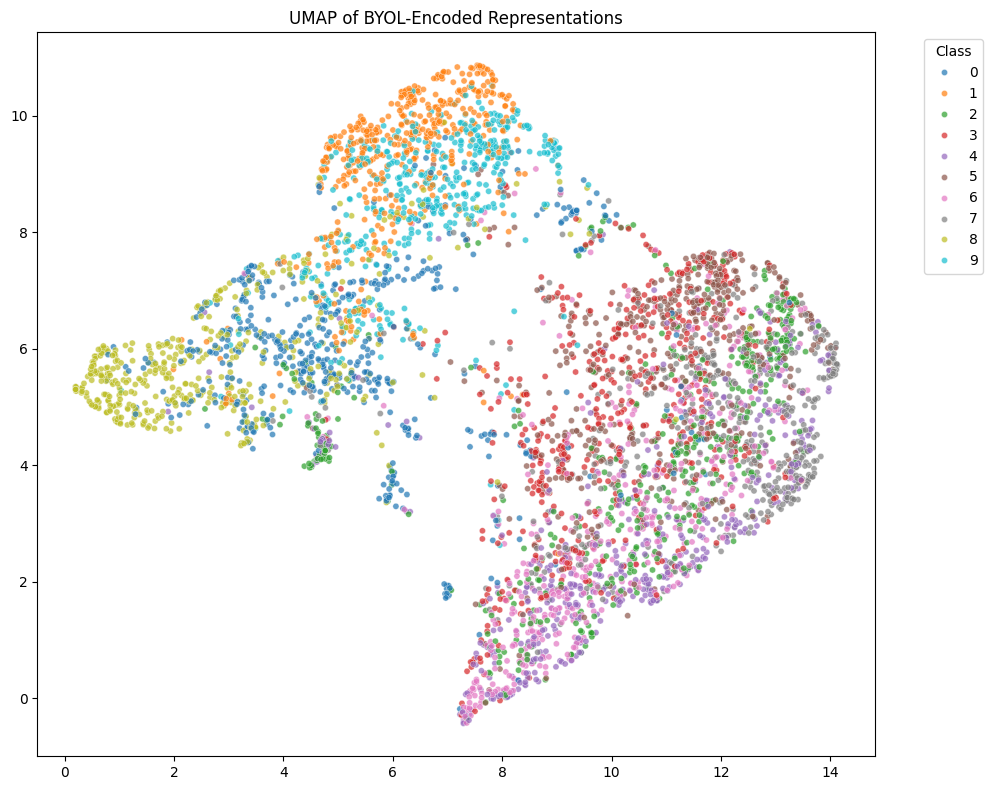

In [63]:
byol_features = get_byol_representations(model_cifar_10_reps.online_encoder, all_features, device=device)
plot_umap(byol_features, all_labels.numpy(), title="UMAP of BYOL-Encoded Representations")

In [64]:
import copy

byol_encoder_frozen = copy.deepcopy(model_cifar_10_reps.online_encoder).to(device).eval()
byol_encoder_finetune = copy.deepcopy(model_cifar_10_reps.online_encoder).to(device)

In [65]:
print("===== Frozen BYOL Encoder =====")
frozen_model, train_losses, val_losses, train_accuracies, val_accuracies = run_experiment(byol_encoder_frozen, freeze_byol=True, epochs=20, return_with_metrics=True)
train_losses, val_losses, train_accuracies, val_accuracies

===== Frozen BYOL Encoder =====


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/20


Train Loss: 3.1298 | Train Acc: 0.4020
Test Loss:  1.3308 | Test Acc:  0.5880

Epoch 2/20


Train Loss: 0.9351 | Train Acc: 0.7232
Test Loss:  0.9588 | Test Acc:  0.7150

Epoch 3/20


Train Loss: 0.5297 | Train Acc: 0.8438
Test Loss:  0.8609 | Test Acc:  0.7630

Epoch 4/20


Train Loss: 0.3689 | Train Acc: 0.9126
Test Loss:  0.7827 | Test Acc:  0.7990

Epoch 5/20


Train Loss: 0.2884 | Train Acc: 0.9526
Test Loss:  0.7806 | Test Acc:  0.8150

Epoch 6/20


Train Loss: 0.2621 | Train Acc: 0.9790
Test Loss:  0.7998 | Test Acc:  0.8240

Epoch 7/20


Train Loss: 0.2321 | Train Acc: 0.9894
Test Loss:  0.7444 | Test Acc:  0.8290

Epoch 8/20


Train Loss: 0.2690 | Train Acc: 0.9784
Test Loss:  0.7457 | Test Acc:  0.8330

Epoch 9/20


Train Loss: 0.2292 | Train Acc: 0.9838
Test Loss:  0.6825 | Test Acc:  0.8380

Epoch 10/20


Train Loss: 0.1327 | Train Acc: 0.9980
Test Loss:  0.6166 | Test Acc:  0.8510

Epoch 11/20


Train Loss: 0.0758 | Train Acc: 0.9996
Test Loss:  0.6037 | Test Acc:  0.8390

Epoch 12/20


Train Loss: 0.0492 | Train Acc: 0.9990
Test Loss:  0.5354 | Test Acc:  0.8480

Epoch 13/20


Train Loss: 0.0401 | Train Acc: 0.9984
Test Loss:  0.5489 | Test Acc:  0.8450

Epoch 14/20


Train Loss: 0.0226 | Train Acc: 0.9992
Test Loss:  0.5625 | Test Acc:  0.8490

Epoch 15/20


Train Loss: 0.0157 | Train Acc: 0.9994
Test Loss:  0.5410 | Test Acc:  0.8620

Epoch 16/20


Train Loss: 0.0153 | Train Acc: 0.9994
Test Loss:  0.5477 | Test Acc:  0.8600

Epoch 17/20


Train Loss: 0.0094 | Train Acc: 1.0000
Test Loss:  0.5535 | Test Acc:  0.8530

Epoch 18/20


Train Loss: 0.0157 | Train Acc: 0.9996
Test Loss:  0.5544 | Test Acc:  0.8420

Epoch 19/20


Train Loss: 0.0090 | Train Acc: 0.9996
Test Loss:  0.5512 | Test Acc:  0.8590

Epoch 20/20


Train Loss: 0.0072 | Train Acc: 0.9998
Test Loss:  0.5578 | Test Acc:  0.8560



([3.129820965576172,
  0.935147405910492,
  0.5296905276298522,
  0.36891373953819273,
  0.28837660217285155,
  0.2620670738220215,
  0.2321015167236328,
  0.26898865456581117,
  0.22917163463830947,
  0.13270859920978545,
  0.07584886898994446,
  0.049176235175132754,
  0.0400809113740921,
  0.02258598673939705,
  0.015707871651649476,
  0.01532435598373413,
  0.00939770450592041,
  0.015708564257621765,
  0.008985311794281007,
  0.007219461762905121],
 [1.3308399982452392,
  0.9588414926528931,
  0.860921926498413,
  0.7826561374664307,
  0.7805757908821106,
  0.7997786326408386,
  0.7444335565567016,
  0.7457470917701721,
  0.6824856505393982,
  0.6166175212860108,
  0.6036733913421631,
  0.5354120302200317,
  0.5489301900863648,
  0.5624857931137085,
  0.5410421612262726,
  0.5477179727554321,
  0.553502146244049,
  0.5544498760700226,
  0.551215815782547,
  0.5577657699584961],
 [0.402,
  0.7232,
  0.8438,
  0.9126,
  0.9526,
  0.979,
  0.9894,
  0.9784,
  0.9838,
  0.998,
  0.999

In [66]:
frozen_byol_scores_ortogonal = {
    'name': 'Resnet with frozen BYOL (with ortogonality)',
    'train_loss': train_losses,
    'val_loss': val_losses,
    'train_accuracy': train_accuracies,
    'val_accuracy': val_accuracies
}

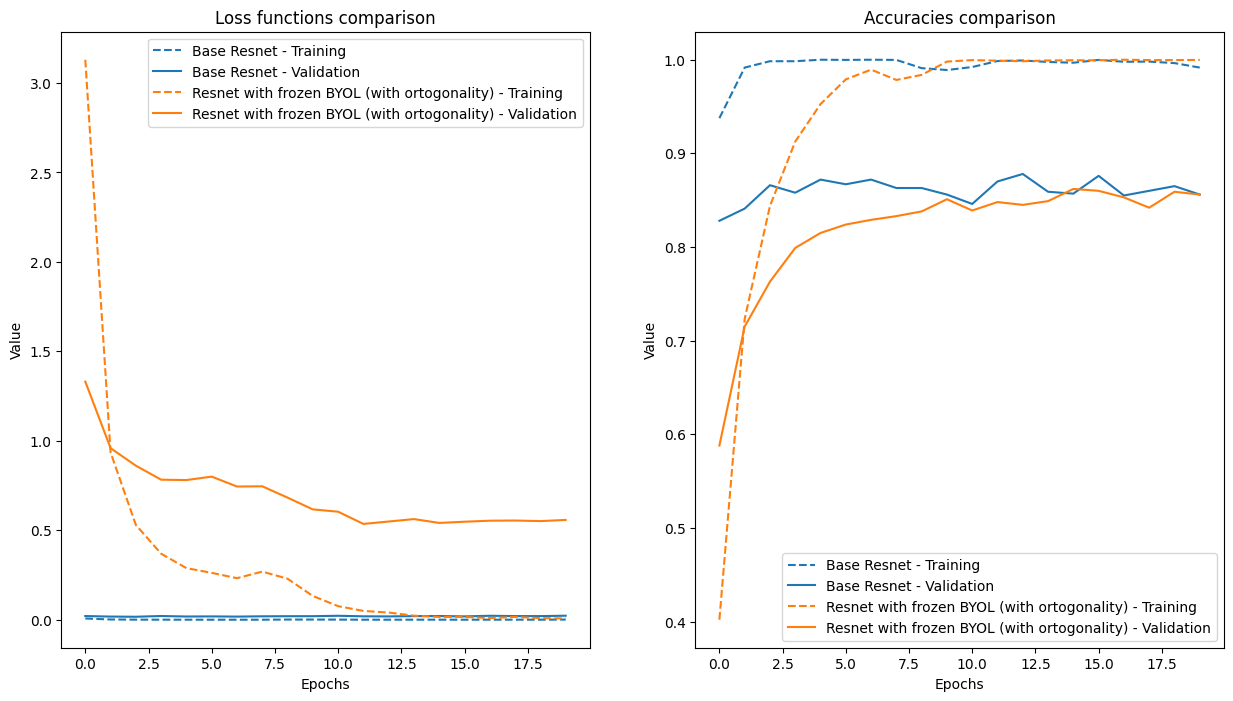

In [67]:
compare_on_plots(base_resnet_scores, frozen_byol_scores_ortogonal)

In [68]:
print("\n===== Fine-tuned BYOL Encoder =====")
finetuned_model, train_losses, val_losses, train_accuracies, val_accuracies = run_experiment(byol_encoder_finetune, freeze_byol=False, epochs=20, return_with_metrics=True)
train_losses, val_losses, train_accuracies, val_accuracies


===== Fine-tuned BYOL Encoder =====


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/20


Train Loss: 3.5369 | Train Acc: 0.3474
Test Loss:  1.3124 | Test Acc:  0.5820

Epoch 2/20


Train Loss: 0.8366 | Train Acc: 0.7514
Test Loss:  0.6738 | Test Acc:  0.8050

Epoch 3/20


Train Loss: 0.3246 | Train Acc: 0.9076
Test Loss:  0.5236 | Test Acc:  0.8320

Epoch 4/20


Train Loss: 0.1277 | Train Acc: 0.9690
Test Loss:  0.5240 | Test Acc:  0.8300

Epoch 5/20


Train Loss: 0.0594 | Train Acc: 0.9892
Test Loss:  0.4933 | Test Acc:  0.8440

Epoch 6/20


Train Loss: 0.0551 | Train Acc: 0.9884
Test Loss:  0.5157 | Test Acc:  0.8480

Epoch 7/20


Train Loss: 0.0102 | Train Acc: 0.9994
Test Loss:  0.5252 | Test Acc:  0.8470

Epoch 8/20


Train Loss: 0.0102 | Train Acc: 0.9982
Test Loss:  0.5435 | Test Acc:  0.8570

Epoch 9/20


Train Loss: 0.0037 | Train Acc: 1.0000
Test Loss:  0.5279 | Test Acc:  0.8610

Epoch 10/20


Train Loss: 0.0061 | Train Acc: 0.9992
Test Loss:  0.5788 | Test Acc:  0.8410

Epoch 11/20


Train Loss: 0.0366 | Train Acc: 0.9888
Test Loss:  0.6506 | Test Acc:  0.8450

Epoch 12/20


Train Loss: 0.0066 | Train Acc: 0.9992
Test Loss:  0.5726 | Test Acc:  0.8630

Epoch 13/20


Train Loss: 0.0021 | Train Acc: 1.0000
Test Loss:  0.5735 | Test Acc:  0.8580

Epoch 14/20


Train Loss: 0.0015 | Train Acc: 1.0000
Test Loss:  0.5940 | Test Acc:  0.8560

Epoch 15/20


Train Loss: 0.0021 | Train Acc: 0.9998
Test Loss:  0.5974 | Test Acc:  0.8550

Epoch 16/20


Train Loss: 0.0640 | Train Acc: 0.9812
Test Loss:  0.8403 | Test Acc:  0.8170

Epoch 17/20


Train Loss: 0.1089 | Train Acc: 0.9656
Test Loss:  0.7644 | Test Acc:  0.8160

Epoch 18/20


Train Loss: 0.0311 | Train Acc: 0.9902
Test Loss:  0.6795 | Test Acc:  0.8420

Epoch 19/20


Train Loss: 0.0353 | Train Acc: 0.9904
Test Loss:  0.7396 | Test Acc:  0.8370

Epoch 20/20


Train Loss: 0.0908 | Train Acc: 0.9732
Test Loss:  0.7450 | Test Acc:  0.8230



([3.536917720413208,
  0.8365545779228211,
  0.32463883152008055,
  0.12765299587249757,
  0.05936656394004822,
  0.05510555305182934,
  0.010157916712760926,
  0.010206944666802883,
  0.0036671302527189254,
  0.006108588474988938,
  0.03661573379188776,
  0.006609147769212723,
  0.002132360115647316,
  0.0014581547923386098,
  0.0020622330255806445,
  0.06398236217498779,
  0.10894789258241654,
  0.031102216625213622,
  0.035282025253772734,
  0.09084381152838468],
 [1.3124251260757447,
  0.6738438849449158,
  0.5235701189041138,
  0.5240228183269501,
  0.49327063822746275,
  0.5156942801475525,
  0.525208575963974,
  0.5435049819946289,
  0.5279113919734955,
  0.5788449602127075,
  0.6505985190868377,
  0.5725808410644532,
  0.5735174489021301,
  0.5939600827693939,
  0.5973776650428771,
  0.8403374238014221,
  0.7644474468231202,
  0.6795231528282165,
  0.7396406307220459,
  0.7449986896514893],
 [0.3474,
  0.7514,
  0.9076,
  0.969,
  0.9892,
  0.9884,
  0.9994,
  0.9982,
  1.0,
  

In [69]:
orogonal_finetuned_byol_scores = {
    'name': 'Resnet with finetuned BYOL (with ortogonality)',
    'train_loss': train_losses,
    'val_loss': val_losses,
    'train_accuracy': train_accuracies,
    'val_accuracy': val_accuracies
}

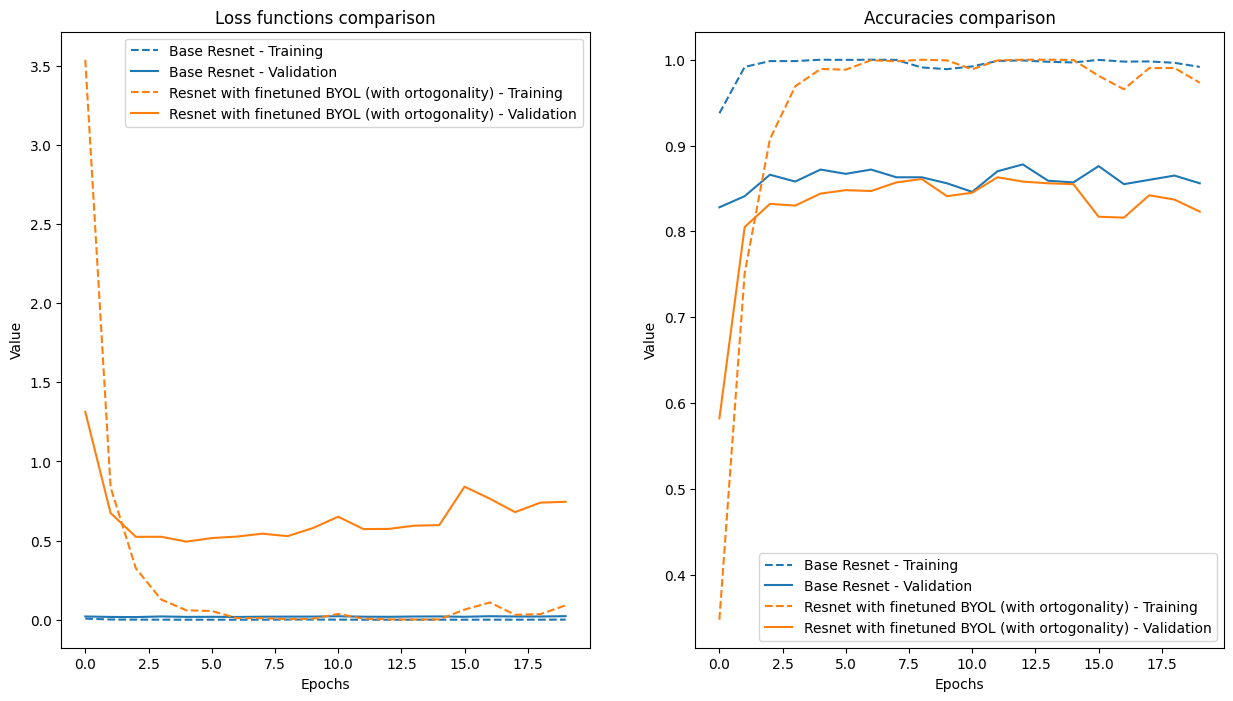

In [70]:
compare_on_plots(base_resnet_scores, orogonal_finetuned_byol_scores)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


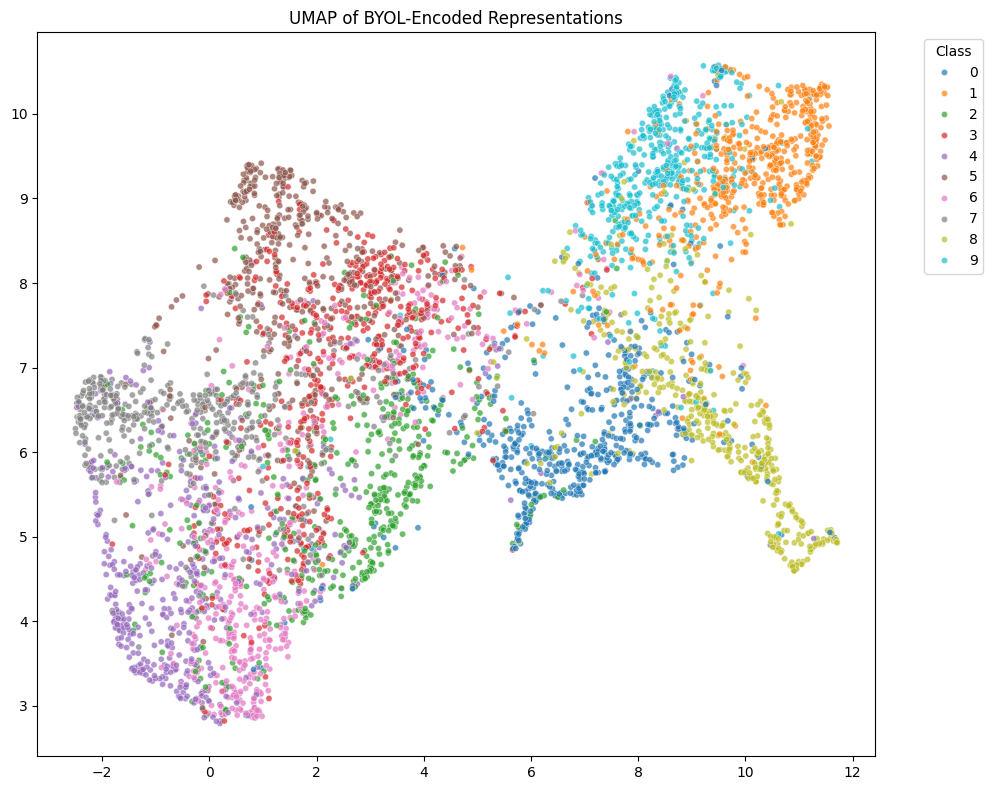

In [71]:
byol_features = get_byol_representations(byol_encoder_finetune, all_features, device=device)
plot_umap(byol_features, all_labels.numpy(), title="UMAP of BYOL-Encoded Representations")